# Machine Learning Based Spectra Classification

Spectroscopy experiment techniques are widely used and produce huge amount of data especially in facilities with very high repetition rates. At the European XFEL, X-ray pulses can be generated with only 220ns separation in time and a maximum of 27000 pulses per second. In experiments (e.g. SCS, FXE, MID and HED) at European XFEL, spectral changes can indicate the change of the system under investigation and so the progress of the experiment. An immediate feedback on the actual status (e.g. time resolved status of the sample) would be essential to quickly judge how to proceed with the experiment. The two major spectral changes what we aim to capture are either the change of intensity distribution (e.g. drop or appearance) of peaks at certain locations, or the shift of those on the spectrum. Machine Learning (ML) opens up new avenues for data-driven analysis in spectroscopy by offering the possibility to quickly recognize such specific changes on-the-fly during data collection. 

ML requires lots of data which are clearly annotated. Hence, it is important that research outputs should align with the FAIR principles. In case of XFEL experiments, we suggest introducing NeXus data format standards in future experiments.

In this work, we present an example to show how Neural Network based ML can be used for accurately classifying the system state if data is properly provided. We demonstrate a solution to automatically find the regions (or bins) with high separability where the spectra classes differ significantly. Teaching individual neural networks for each bin and combining them with a weighting technique, a robust classification of any new spectral curve can be quickly obtained. 

### Create the data

In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
from cycler import cycler
import matplotlib.style
import matplotlib as mpl
import matplotlib.cm as cm

In [2]:
import matplotlib
print(matplotlib.get_configdir())
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
                                             

/home/sunyue/.config/matplotlib


In [3]:
%matplotlib notebook
import glob, os, os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import bisect
import scipy.sparse as sparse  #for baseline subtraction
from matplotlib import rc
# rc('mathtext', default='regular')
import h5py
# torch.set_printoptions(threshold=100000)
# plt.style.use('science')

In [4]:
hfont = {'fontname':'Helvetica'}

In [5]:
'''Definitions'''

def gaussian(x, x0, r, a, b):
    y = b + a*np.exp(-(x-x0)**2/(2*r**2))
    return y

def PseudoVoigtFunction(WavNr, Pos, Amp, GammaL, FracL):
    SigmaG = GammaL / np.sqrt(2*np.log(2)) # Calculate the sigma parameter  for the Gaussian distribution from GammaL (coupled in Pseudo-Voigt)
    LorentzPart = Amp / np.pi * (GammaL / ((WavNr - Pos)**2 + GammaL**2)) # Lorentzian distribution
    GaussPart = Amp / (np.sqrt(2*np.pi) * SigmaG) * np.exp( -(WavNr - Pos)**2 / (2 * SigmaG**2)) # Gaussian distribution
    Fit = FracL * LorentzPart + (1 - FracL) * GaussPart # Linear combination of the two parts (or distributions)
    return Fit

#baseline subtraction based on Asymetric Least Square Smoothing
#https://zanran_storage.s3.amazonaws.com/www.science.uva.nl/ContentPages/443199618.pdf
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = sparse.linalg.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# Function which extracts the number of all XYfiles in the directory.    
run_no=0
def get_number_XYfiles(run_no):
    directory = os.listdir('data/')
    number_XYfiles = run_no
    for Dir in directory:
        number_XYfiles = number_XYfiles+1
    return(number_XYfiles)

In [6]:
# show the number of XYfiles found in the directory
total_XYfiles = get_number_XYfiles(run_no)
print(total_XYfiles)
total_XYfiles=350 #[Pt=1084, MgFeOB1_263]
print('The number of XYfiles within the chosen run is:', total_XYfiles)
save_figures_to = '../ClassificationFigures/'

350
The number of XYfiles within the chosen run is: 350


In [7]:
'''make sure that you have the right command directory selected'''
%cd data/
theta = [] 
I = []
baseline = []
Icorrect = []
test_y=total_XYfiles-2
for run_no in range(1,0+total_XYfiles):
    fileNO = str(run_no).zfill(4) 
    fname = 'l2_fe80mg20_ramp_00001_m1_'+str(run_no).zfill(4)+'.xy'
    thetas, Is = np.loadtxt(fname, skiprows=25, unpack=True) # reads all files in range and assigns 1st column to thetas and 2nd to Is
    I.append(Is) # attaches a new array each time to a copy of previous, not really necessary here
    idx1 = 0
    idx2 = 4050
#background subtraction
#parameters lam and p have to be adjusted by hand!
#try 10**2 < lam < 10**9
#    0.001 <  p  < 0.1
    lam = 100000
    p = 0.002
    baselines = baseline_als(Is[idx1:idx2], lam, p)
    baseline.append(baselines)
    Icorrected = Is[idx1:idx2] - baselines
    Icorrect.append(Icorrected)
#    if (run_no==15): 
#        print(thetas.size, Is.shape,type(I),np.shape(I),len(Icorrected),len(baselines),sep='\n')
    thetas = thetas[idx1:idx2]
    theta.append(thetas)

/gpfs/exfel/data/user/sunyue/Spectra classification 20201122/data


<IPython.core.display.Javascript object>


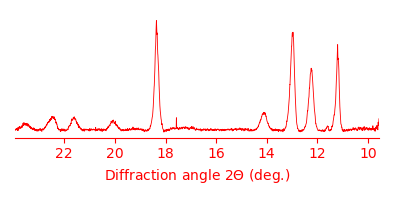

In [8]:
'''make sure that you have the right command directory selected'''
run_no =1
id_s = 0
id_n = 3620 #3700 #3350
I_temp = Icorrect[run_no][id_s:id_n]
t_temp = theta[run_no][id_s:id_n]     
    
fig, ax = plt.subplots(figsize=(4,2))
plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16
c='red'
# c='limegreen'
plt.ylabel('Intensity',color = c )
plt.xlabel('Diffraction angle 2$\Theta$ (deg.)',color = c )
ax.plot(t_temp, I_temp, color = c ,lw=0.6)
# ax.axis['right'].set_visible(False)
# ax.axis["top"].set_visible(False)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_yaxis().set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.tick_params(axis='x', colors=c)
ax.tick_params(axis='y', colors=c)
ax.spines["left"].set_color(c)
ax.spines["bottom"].set_color(c)
ax.set_xlim(theta[run_no][id_s],theta[run_no][id_n])
ax.invert_xaxis()  # labels read top-to-bottom
# fig.patch.set_alpha(0.9)
# fig.set_facecolor(c)
plt.tight_layout()
plt.show()

plt.savefig(save_figures_to+"2D diffraction pattern.png", bbox_inches='tight',  transparent=True, dpi=300)

In [9]:
print(theta[0].shape,np.size(theta),len(theta),np.size(theta[0]))

(4023,) 1404027 349 4023


In [10]:
angle = np.asarray(theta)
intensity=np.asarray(Icorrect)
print(type(theta),type(angle),angle.shape,intensity.shape)

<class 'list'> <class 'numpy.ndarray'> (349, 4023) (349, 4023)


(349, 4023) (349, 4023)


<IPython.core.display.Javascript object>


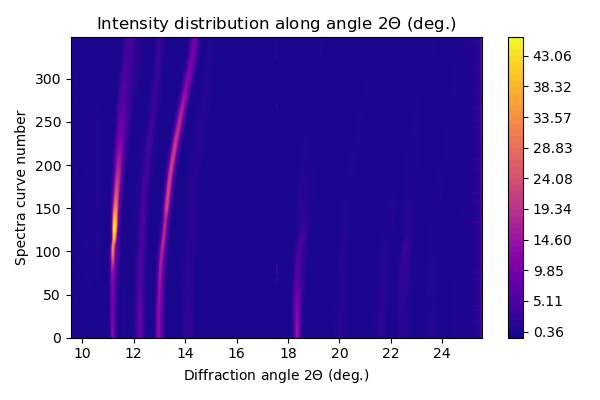

45.90664283740434


In [11]:
angle     = np.asarray(theta)
intensity = np.asarray(Icorrect)
print(angle.shape,intensity.shape)
plt.figure(figsize=(6,4))

H_value   = np.max(intensity)
L_value   = np.min(intensity)
print(H_value)
x_vals    = angle[0] # all the spectral curves have the same x-axis, called the 
y_vals    = np.arange(0,len(angle))
X, Y      = np.meshgrid(x_vals, y_vals)
level_n   = 100

Z         = intensity
cp        = plt.contourf(X, Y, Z,levels=level_n,vmin = L_value, vmax = H_value,cmap=cm.plasma)
plt.ylabel('Spectra curve number')
plt.xlabel('Diffraction angle 2$\Theta$ (deg.)')

m = plt.cm.ScalarMappable(cmap=cm.plasma)
m.set_array(Z)
m.set_clim(L_value, H_value)
plt.colorbar(m, boundaries=np.linspace(L_value, H_value))
plt.show()

plt.title('Intensity distribution along angle 2$\Theta$ (deg.) ')

plt.tight_layout()
plt.savefig(save_figures_to+"all curves intensity distribution.png", bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


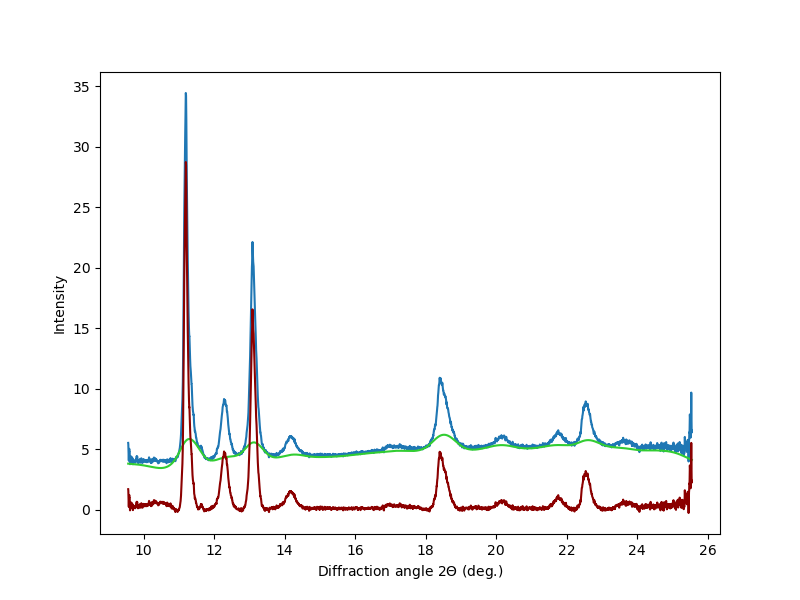

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [12]:
plt.figure(figsize=(8,6))
plt.plot(theta[98], I[98][idx1:idx2])
plt.plot(theta[98], baseline[98],color = 'limegreen')
plt.plot(theta[98], Icorrect[98], color = 'darkred')

plt.ylabel('Intensity')
plt.xlabel('Diffraction angle 2$\Theta$ (deg.)')
plt.tight_layout

In [13]:
def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity', )#fontsize = 16,
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', )#fontsize = 16
#     plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    
    plt.rc('xtick') #,labelsize=16
    plt.rc('ytick') #,labelsize=16
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.4, cmap=plt.cm.rainbow)

In [14]:
def minibatch_plot_data(X, y, ai1=-1,ai2=1,bi1=-1,bi2=1,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.6, cmap=plt.cm.rainbow)
#     plt.axis('square')
#     plt.axis(np.array((ai1, ai2, bi1, bi2)) * zoom)
#     if auto is True: plt.axis('equal')
    plt.axis('on') 
    
def minibatch_plot_model(mndinx1,mndinx2,mndiny1,mndiny2,X2, y2, model):
    model.cpu()
    X2 = X2.cpu()
    y2 = y2.cpu()
    mndinx1 = mndinx1.cpu()
    mndinx2 = mndinx2.cpu()
    
    x = np.arange(mndinx1, mndinx2, 0.001)
    y = np.arange(mndiny1, mndiny2, 0.001)
    xx, yy = np.meshgrid(x, y)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
    minibatch_plot_data(X2, y2,mndinx1,mndinx2,mndiny1,mndiny2,zoom=1)

In [15]:
def set_default(figsize=(8,6)):
#     plt.style.use(['dark_background', 'bmh'])
#     plt.rc('figure', facecolor='none')
    plt.rc('figure', figsize=figsize)
    
def yue_plot_data(X, y, axl,axr,byl,byh,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity') # fontsize = 16,
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')#, fontsize = 16
    plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    
    plt.rc('xtick') #,labelsize=16
    plt.rc('ytick') #,labelsize=16
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.6, cmap=plt.cm.rainbow)


def ys_plot_model(X, y, model):
    plt.figure(figsize=(8,6))
    bx = plt.subplot(111)
#     bx.set_ylabel('Intensity', )#fontsize = 16,
#     bx.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', )#fontsize = 16
    plt.axis([axl, axr, byl, byh])
    
    
    model.cpu()
    X=X.cpu()
    mesh1 = np.arange(axl, axr, 0.01)
    mesh2 = np.arange(byl, byh, 0.01)
    xx, yy = np.meshgrid(mesh1, mesh2)
    
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float().cpu()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)     
    yue_plot_data(X, y, axl,axr,byl,byh)

In [16]:
set_default()

In [17]:
Spec_len = np.size(theta[0])
B = 15 # num of bins
iternum=700
global N2
N2=int(Spec_len/B)
# N = np.size(theta[0])  # num_samples_per_class
N = N2*B  # num_samples_per_class

D = 2  # dimensions
C = 2  # num_classes
H = 150 # num_hidden_units

S = 0 #bin id
Si=0


print(N2,N2*B,Spec_len,N)

268 4020 4023 4020


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###  data for training

In [19]:
p0_num=  4 #0 # 4
p1_num= 15 #7 #13
p2_num= 13 #10 # 9
p3_num=  6 #15 # 15

<IPython.core.display.Javascript object>


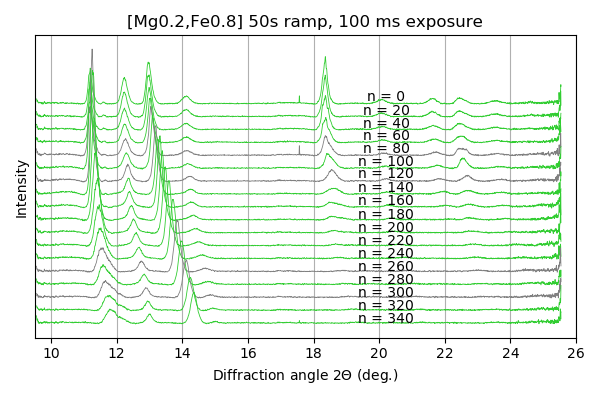

(4020,) 18 10


In [20]:

fig, ax = plt.subplots(figsize=(6,4))
plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16

# These are the colors that will be used in the plot
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']



X_1 = []# training: theta
X_2 = []# training: intensity
y   = []
global Ci,Ci_0,div_num,gap #indicates num of curves, and curves of class0.
div_num = 185 #indicates the boundary of spectral curves.
gap = 20
Ci = 0  
Ci_0 = 0
for pct in range(0,total_XYfiles,gap):
    shift = 12-pct/5.
    ax.plot(theta[pct][0:N], Icorrect[pct][0:N]+shift, color = 'grey' if pct == p0_num*gap or pct ==p1_num*gap or pct ==p2_num*gap or pct ==p3_num*gap else 'limegreen' ,lw=0.6)
    Ci += 1
    if pct <div_num:
        Ci_0 += 1
    
    Icorrect_t = Icorrect[pct]
    theta_t = theta[pct]
    X_1.append(theta_t[0:N])
    X_2.append(Icorrect_t[0:N])
    ax.text(theta_t[int(2*N/3)], Icorrect_t[int(2*N/3)]+shift, "n = %i" % (pct) , size=10, ha="center", color="k")
             
print(X_1[0].shape,Ci,Ci_0)


ax.set_ylabel('Intensity', )
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)',)
ax.set_xlim(9.5,26)
plt.grid(True)
plt.title('[Mg0.2,Fe0.8] 50s ramp, 100 ms exposure') #,  fontweight='bold'
ax.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig(save_figures_to+"Original data used for training.png", bbox_inches='tight', dpi=300)

(18, 4020) (18, 4020)


<IPython.core.display.Javascript object>


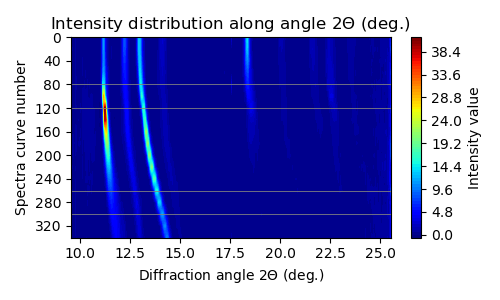

-0.2905587471483395 40.985091814607784


In [21]:

angle     = np.asarray(X_1)
intensity = np.asarray(X_2)
print(angle.shape,intensity.shape)
fig, ax = plt.subplots(figsize=(5,3))

H_value   = np.max(intensity)
L_value   = np.min(intensity)
print(L_value,H_value)
x_vals    = angle[0] # all the spectral curves have the same x-axis, called the 
y_vals    = np.arange(0,len(angle))*20
X, Y      = np.meshgrid(x_vals, y_vals)

Z         = intensity
level_n   = 80
cmap_temp = cm.jet

cp        = ax.contourf(X, Y, Z,levels=level_n,vmin = L_value, vmax = H_value,cmap=cmap_temp)


plt.ylabel('Spectra curve number')
plt.xlabel('Diffraction angle 2$\Theta$ (deg.)')

ax.invert_yaxis()  # labels read top-to-bottom

plt.yticks(np.arange(len(angle),-1,-2)*20)
ax.set_ylim((len(angle)-1)*20, 0)

ax.axhline(y=p0_num*20, color="grey",lw=0.6)
ax.axhline(y=p1_num*20, color="grey",lw=0.6)
ax.axhline(y=p2_num*20, color="grey",lw=0.6)
ax.axhline(y=p3_num*20, color="grey",lw=0.6)


cbar = fig.colorbar(cp)
cbar.ax.set_ylabel('Intensity value')


plt.title('Intensity distribution along angle 2$\Theta$ (deg.) ')
plt.tight_layout()
plt.savefig(save_figures_to+"Trends intensity distribution.png", bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


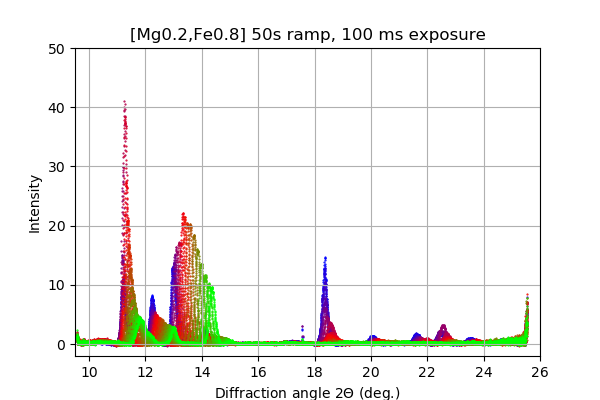

In [22]:
#plotting spectra in another way
plt.figure(figsize=(6,4))

ax = plt.subplot(111)
t_gap=20 # this parameter decide the number of spectral curves for test.

import matplotlib.cm as cm
colors = cm.brg(np.linspace(0, 1, len(range(0,total_XYfiles-1,t_gap)))) # or gist_rainbow
pos_d=0
for pct,cc in zip(range(0,total_XYfiles-1,t_gap),colors):
    pct = pct+pos_d
    plt.scatter(theta[pct][0:N], Icorrect[pct][0:N], color=cc,s=0.3)
    
ax.set_ylabel('Intensity')
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)',)
ax.set_ylim(-2,50)
ax.set_xlim(9.5,26)
plt.grid(True)
plt.title('[Mg0.2,Fe0.8] 50s ramp, 100 ms exposure') #,  fontweight='bold'
plt.savefig(save_figures_to+"Spectra data for testing (manually classified).png", bbox_inches='tight', dpi=300)

plt.tight_layout()


torch.Size([18, 4020])
torch.Size([72360, 1])


<IPython.core.display.Javascript object>


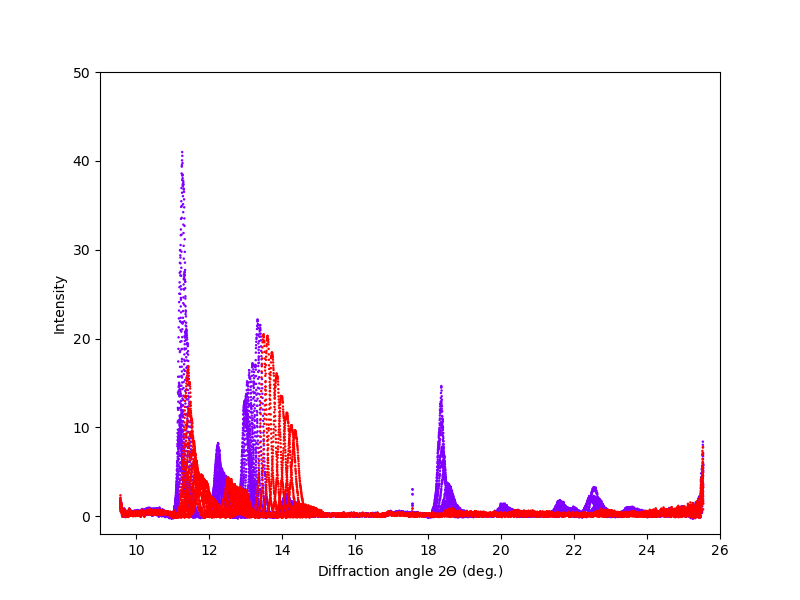

In [23]:
# data for training

global axl,axr,byl,byh,Ci
X_1=torch.FloatTensor(X_1)
X_2=torch.FloatTensor(X_2)
print(X_1.shape)
X_1=torch.reshape(X_1,(-1,1))
X_2=torch.reshape(X_2,(-1,1))
print(X_1.shape)
XX=torch.cat((X_1,X_2),1).to(device)

y_1 = torch.zeros(Ci_0 * (N), dtype=torch.long)
y_2 = torch.ones((Ci-Ci_0)* (N), dtype=torch.long)
y   = torch.cat((y_1,y_2),0).to(device)

axl=9
axr=26
byl=-2
byh=50

plt.figure(figsize=(8,6))
yue_plot_data(XX, y, axl,axr,byl,byh)
plt.savefig(save_figures_to+"Original data used for training(manually classified).png", bbox_inches='tight', dpi=300)


# pick four extreme curves and add some random noise to train the model

In [24]:
print(XX.shape,y.shape)

torch.Size([72360, 2]) torch.Size([72360])


torch.Size([16080, 2])
torch.Size([176880, 2]) torch.Size([176880])


<IPython.core.display.Javascript object>


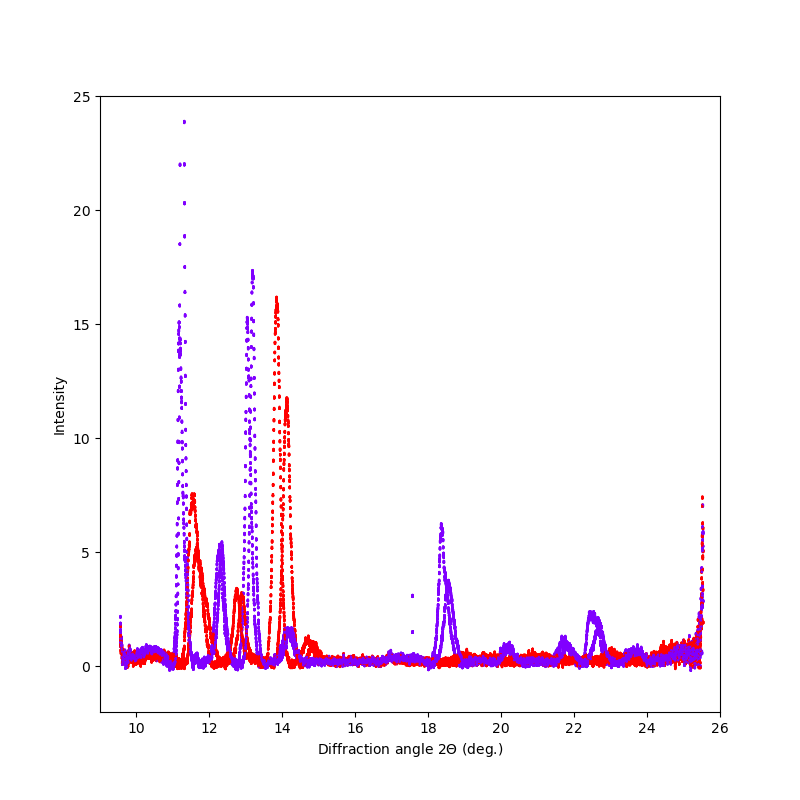

In [25]:
global D_len
D_len=N
# pick 4 extreme curves to train the model
pnum_curves=4

Xtemp1=XX[D_len*p0_num:D_len+D_len*p0_num,:]
Xtemp2=XX[D_len*p1_num:D_len+D_len*p1_num,:]
Xtemp3=XX[D_len*p2_num:D_len+D_len*p2_num,:]
Xtemp4=XX[D_len*p3_num:D_len+D_len*p3_num,:]
X_Extrem= torch.empty(0,2)
X_Extrem=torch.cat((Xtemp1,Xtemp2,Xtemp3,Xtemp4),0)
X_Extrem_tmp = X_Extrem
print(X_Extrem.shape)

ytemp1=y[D_len*p0_num:D_len+D_len*p0_num]
ytemp2=y[D_len*p1_num:D_len+D_len*p1_num]
ytemp3=y[D_len*p2_num:D_len+D_len*p2_num]
ytemp4=y[D_len*p3_num:D_len+D_len*p3_num]
y_Extrem=torch.cat((ytemp1,ytemp2,ytemp3,ytemp4),0)

# add some noise to training data sets

N_sim=10 # simulated spectra 
for n in range(N_sim):
    seed = n*1000
    random.seed(seed)
    torch.manual_seed(seed)
    for i in range(D_len*pnum_curves):
        X_Extrem_tmp[i,1] = X_Extrem[i,1] +random.random()/12

    X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0)
    y_Extrem_tmp=torch.cat((ytemp1,ytemp2,ytemp3,ytemp4),0)
    y_Extrem    =torch.cat((y_Extrem,y_Extrem_tmp),0)    

print(X_Extrem.shape,y_Extrem.shape)
plt.figure(figsize=(8,8))
byh_reprst=25
yue_plot_data(X_Extrem, y_Extrem, axl,axr,byl,byh_reprst)


In [26]:
global N_Train
N_Train=pnum_curves*(N_sim+1)

### data for testing

<IPython.core.display.Javascript object>


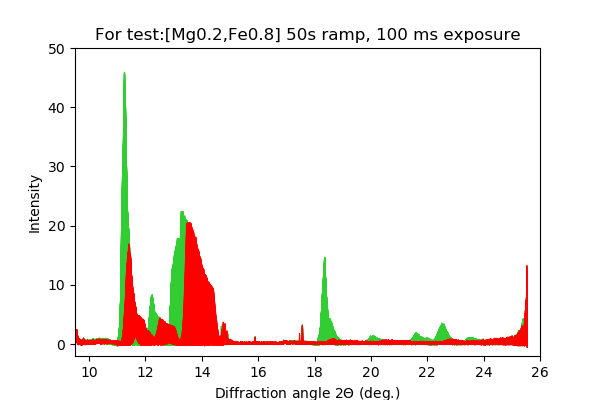

349 <class 'list'> <class 'list'>
349 185


In [27]:
#plotting various plots to show development of bcc -> hcp transition
plt.figure(figsize=(6,4))

plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16

# These are the colors that will be used in the plot
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

ax = plt.subplot(111)

Xt_1 = []# theta for test
Xt_2 = []# intensity for test
yt   = []
global Ntn,Ntn_0 #indicates num of test curves, and curves of class0.
Ntn = 0  # num of test curves,
Ntn_0 = 0 #and num of curves of class0
pos_d=0
t_gap=1
for pct in range(0,total_XYfiles-1,t_gap):
    pct = pct+pos_d
    ax.plot(theta[pct], Icorrect[pct], color = 'limegreen' if pct <200 else 'red',lw=0.8)
    Ntn += 1
    if pct <div_num:
        Ntn_0 += 1

    Icorrect_t = Icorrect[pct]
    theta_t = theta[pct]
    Xt_1.append(theta_t[0:N])
    Xt_2.append(Icorrect_t[0:N])

print(len(Xt_1),type(Xt_1),type(yt))            


ax.set_ylabel('Intensity',)
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')
ax.set_ylim(-2,50)
ax.set_xlim(9.5,26)

plt.title('For test:[Mg0.2,Fe0.8] 50s ramp, 100 ms exposure')
plt.savefig(save_figures_to+"Spectra data for testing (manually classified).png", bbox_inches='tight', dpi=300)

plt.tight_layout()
print(Ntn,Ntn_0)

<class 'list'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


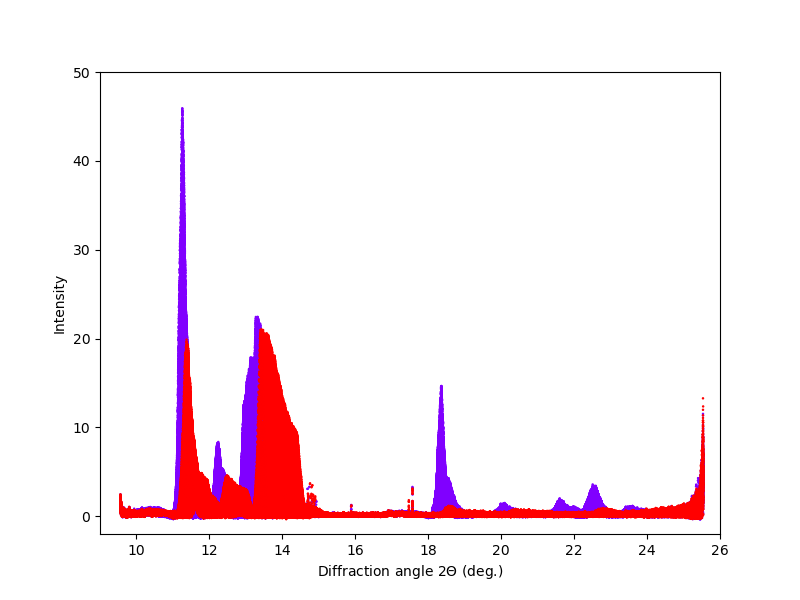

In [28]:
# data for testing
global Xt,yt
print(type(Xt_1))
Xt_1=torch.FloatTensor(Xt_1) # convert list type to tensor
Xt_2=torch.FloatTensor(Xt_2) # convert list type to tensor
Xt_1=torch.reshape(Xt_1,(-1,1))
Xt_2=torch.reshape(Xt_2,(-1,1))


Xt=torch.cat((Xt_1,Xt_2),1).to(device)

yt_1 = torch.zeros(Ntn_0 * (N), dtype=torch.long)
yt_2 = torch.ones((Ntn-Ntn_0)* (N), dtype=torch.long)
yt   = torch.cat((yt_1,yt_2),0).to(device)
print(type(Xt_1),type(yt))

plt.figure(figsize=(8,6))
yue_plot_data(Xt, yt, axl,axr,byl,byh)

In [29]:
print('Xt:',Xt.shape)
print('X_Extrem:',X_Extrem.shape,y_Extrem.shape,sep='\n')
print(X.shape,y.shape)


Xt: torch.Size([1402980, 2])
X_Extrem:
torch.Size([176880, 2])
torch.Size([176880])
(18, 4020) torch.Size([72360])


# training process

# pick four extreme curves for training

In [30]:
# train NN in each bin
def TrainingProc(S2):
    global X2,y2
    X2 = torch.zeros(N2 * N_Train, D).to(device)
    y2 = torch.zeros(N2 * N_Train, dtype=torch.long).to(device)    

    for ix in range(N2):
        for ic in range(N_Train):
            X2[ix+ic*N2] = X_Extrem[S2*N2+ix+ic*N]
            y2[ix+ic*N2] = y_Extrem[S2*N2+ix+ic*N]

    learning_rate = 8e-3
    lambda_l2 = 2e-5
    # nn package to create our linear model
    # each Linear module has a weight and bias

    model = nn.Sequential(
        nn.Linear(D, H),
        nn.ReLU(),
#         nn.Linear(H, int(H/C)),
#         nn.ReLU(),
#         nn.Linear(int(H/C), H),
#         nn.ReLU(),
        nn.Linear(H, C)
    )
    model.to(device)

    # nn package also has different loss functions.
    # we use cross entropy loss for our classification task
    criterion = torch.nn.CrossEntropyLoss()

    # we use the optim package to apply
    # ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
    #optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, betas=(0.8, 0.999), eps=1e-08, weight_decay=0) # built-in L2

    # e = 1.  # plotting purpose

    # Training
    dh=display.display("Training",display_id=True)
    for t in range(iternum):
        # Feed forward to get the logits
        y_pred = model(X2)
    
        # Compute the loss and accuracy
        loss = criterion(y_pred, y2)
        score, predicted = torch.max(y_pred, 1)
        acc = (y2 == predicted).sum().float() / len(y2)
        dh.update("[BIN]: %i, [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (S2, t, loss.item(), acc))
        #display.clear_output(wait=True)
              
        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()
    
        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()
    
        # Update params
        optimizer.step()
        
    #print(len(y2),y_pred.size(),loss,sep='\n') 
    
    return acc,model

<class 'list'>


<IPython.core.display.Javascript object>


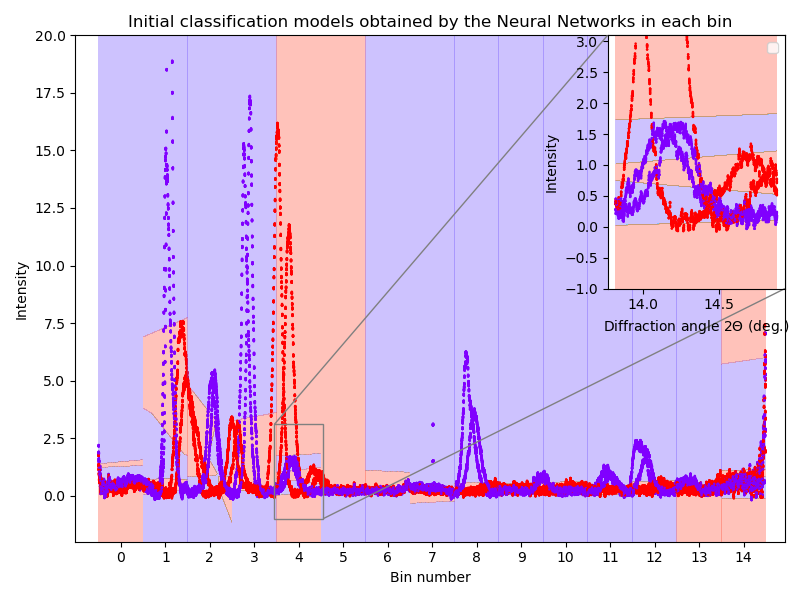

'[BIN]: 0, [EPOCH]: 699, [LOSS]: 0.638227, [ACCURACY]: 0.630'

'[BIN]: 1, [EPOCH]: 699, [LOSS]: 0.591936, [ACCURACY]: 0.656'

'[BIN]: 2, [EPOCH]: 699, [LOSS]: 0.612646, [ACCURACY]: 0.672'

'[BIN]: 3, [EPOCH]: 699, [LOSS]: 0.615972, [ACCURACY]: 0.644'

'[BIN]: 4, [EPOCH]: 699, [LOSS]: 0.519209, [ACCURACY]: 0.730'

'[BIN]: 5, [EPOCH]: 699, [LOSS]: 0.615475, [ACCURACY]: 0.644'

'[BIN]: 6, [EPOCH]: 699, [LOSS]: 0.692877, [ACCURACY]: 0.512'

'[BIN]: 7, [EPOCH]: 699, [LOSS]: 0.655837, [ACCURACY]: 0.616'

'[BIN]: 8, [EPOCH]: 699, [LOSS]: 0.438952, [ACCURACY]: 0.781'

'[BIN]: 9, [EPOCH]: 699, [LOSS]: 0.601145, [ACCURACY]: 0.661'

'[BIN]: 10, [EPOCH]: 699, [LOSS]: 0.636962, [ACCURACY]: 0.623'

'[BIN]: 11, [EPOCH]: 699, [LOSS]: 0.527643, [ACCURACY]: 0.711'

'[BIN]: 12, [EPOCH]: 699, [LOSS]: 0.508016, [ACCURACY]: 0.730'

'[BIN]: 13, [EPOCH]: 699, [LOSS]: 0.653541, [ACCURACY]: 0.625'

'[BIN]: 14, [EPOCH]: 699, [LOSS]: 0.692182, [ACCURACY]: 0.507'

coutour Z: tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


No handles with labels found to put in legend.


Accuracy:
tensor([0.6304, 0.6560, 0.6717, 0.6437, 0.7300, 0.6437, 0.5124, 0.6164, 0.7810,
        0.6608, 0.6230, 0.7115, 0.7303, 0.6251, 0.5069])
Weights: 
tensor([0.1361, 0.1833, 0.2132, 0.1603, 0.3303, 0.1603, 0.0000, 0.1109, 0.4409,
        0.1923, 0.1228, 0.2921, 0.3310, 0.1265, 0.0000])


In [31]:
# pick two extreme curves for training and generate test data in each bin
# seed = 12345
# random.seed(seed)
# torch.manual_seed(seed)

global Acc,N2
global W
N2=int(N/B)
Acc=torch.zeros(B)
W=torch.zeros(B)
y_pred_union=[]
print(type(y_pred_union))


byhigh=20
X2t = torch.zeros(N2* Ntn, C).to(device) # test data curve in each bin
ytest_pred=[]

In_Bias=(axr-axl)/B
# fig = plt.figure(figsize=(8,6))
fig, ax1 = plt.subplots()
plt.axis(np.array((axl, axr, byl, byhigh)))

for b in range(B):
    Acc[b], model =TrainingProc(b)
    
    
    with torch.no_grad(): 
        y_pred= model(X2) # 
       
    y_pred= y_pred.cpu()
    y_pred=y_pred.numpy()## convert tensor to numpy
    y_pred= np.argmax(y_pred, axis=1)
    y_pred_union.append(y_pred)    
    
    #spectral data in every bin.
    for jn in range(Ntn):  # curves belong to each class 
        for n in range(N2):
            X2t[n + jn*N2,: ] = Xt[n + jn*N + b*N2,:] 
    with torch.no_grad(): 
        y2t= model(X2t)# use model in each bin to predict label of test data curves belong to each bin             
        y2t= y2t.cpu() 
    
    y2t=y2t.numpy()## convert tensor to numpy
    y2t= np.argmax(y2t, axis=1)
    ytest_pred.append(y2t)
    
    if b==4:
        x_fst      = X2[0,0]# x-axis start point
        x_e        = X2[-1,0] # x-axis end point
        by_inlet_l = -1
        by_inlet_h = 3.1
        X2_inlet   = X2[X2[:,1]<by_inlet_h]
        y2_inlet   = y2[X2[:,1]<by_inlet_h]
        model_inlet= model
        
    # Plot data curves in each bin
    din1=X2[0,0] # x-axis start point
    din2=X2[-1,0] # x-axis end point
    minibatch_plot_model(din1, din2, byl, byhigh, X2, y2, model)

W = np.maximum(1.4337*Acc**2-0.4337,0)
plt.title('Initial classification models obtained by the Neural Networks in each bin',horizontalalignment='center')



n          = 0
middle_p   = int(N2/2)
x_dataTick = np.zeros(B) 
labels     = np.arange(B) 
for b in range(0,B):
    index         = b*N2+middle_p
    x_dataTick[n] = theta[0][index]
    labels[n]     = b
    n             = n+1
plt.xticks(x_dataTick,labels,)#fontsize=16
# print(x_dataTick,labels)



# Create a set of inset Axes: these should fill the bounding box allocated to# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
# ip = InsetPosition(ax1, [0.75,0.4,0.25,0.6])
ip = InsetPosition(ax1, [0.75,0.5,0.25,0.5])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')


# The data: only display for 
# minibatch_plot_model(fig=ax2,x_fst,x_e,byl,by_inlet_h,X2_inlet, y2_inlet, model)

model_inlet.cpu()
x_fst = x_fst.cpu()
x_e = x_e.cpu()
x = np.arange(x_fst, x_e, 0.001)
y = np.arange(by_inlet_l, by_inlet_h, 0.001)
xx, yy = np.meshgrid(x, y)
with torch.no_grad():
    data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model_inlet(data).detach()
Z = np.argmax(Z, axis=1).reshape(xx.shape) 
print('coutour Z:',Z)
ax2.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)

X = X2_inlet.cpu()
y = y2_inlet.cpu()
ax2.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.6, cmap=plt.cm.rainbow)
ax2.axis('on')
ax2.legend(loc=0)

# Some ad hoc tweaks.
ax2.set_yticks(np.arange(by_inlet_l,by_inlet_h,0.5))
# ax2.set_xticks(np.arange(x_fst,x_e,0.4))
# ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w')
# ax2.tick_params(axis='x', which='major', pad=8)






plt.show()

ax1.set_ylabel('Intensity', )#fontsize = 16,
ax2.set_ylabel('Intensity', )#fontsize = 16,
ax1.set_xlabel('Bin number')#, fontsize = 16
ax2.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')#, fontsize = 16

plt.tight_layout()
plt.savefig(save_figures_to+"Applying different model in different bins.png", bbox_inches='tight', dpi=600)

print("Accuracy:",Acc,"Weights: ",W,sep='\n')
    


In [32]:
####Bin interval
print(N_Train,X_Extrem.shape)
for b in range(B):  
    S2=b
    for ix in range(N2):
        for ic in range(N_Train):
            X2[ix+ic*N2] = X_Extrem[S2*N2+ix+ic*N]
            y2[ix+ic*N2] = y_Extrem[S2*N2+ix+ic*N]
    din1=X2[0,0] # x-axis start point
    din2=X2[-1,0] # x-axis end point
    print('Bin interval:',din1,din2)        

44 torch.Size([176880, 2])
Bin interval: tensor(9.5604) tensor(10.6218)
Bin interval: tensor(10.6258) tensor(11.6872)
Bin interval: tensor(11.6912) tensor(12.7527)
Bin interval: tensor(12.7566) tensor(13.8181)
Bin interval: tensor(13.8221) tensor(14.8835)
Bin interval: tensor(14.8875) tensor(15.9489)
Bin interval: tensor(15.9529) tensor(17.0143)
Bin interval: tensor(17.0183) tensor(18.0798)
Bin interval: tensor(18.0837) tensor(19.1452)
Bin interval: tensor(19.1491) tensor(20.2106)
Bin interval: tensor(20.2146) tensor(21.2760)
Bin interval: tensor(21.2800) tensor(22.3414)
Bin interval: tensor(22.3454) tensor(23.4068)
Bin interval: tensor(23.4108) tensor(24.4723)
Bin interval: tensor(24.4762) tensor(25.5377)


In [33]:
# pick four extreme curves to train the model
Xtrain1 = Xtemp1.cpu().numpy() 
Xtrain2 = Xtemp2.cpu().numpy() 
Xtrain3 = Xtemp3.cpu().numpy() 
Xtrain4 = Xtemp4.cpu().numpy() 

<IPython.core.display.Javascript object>


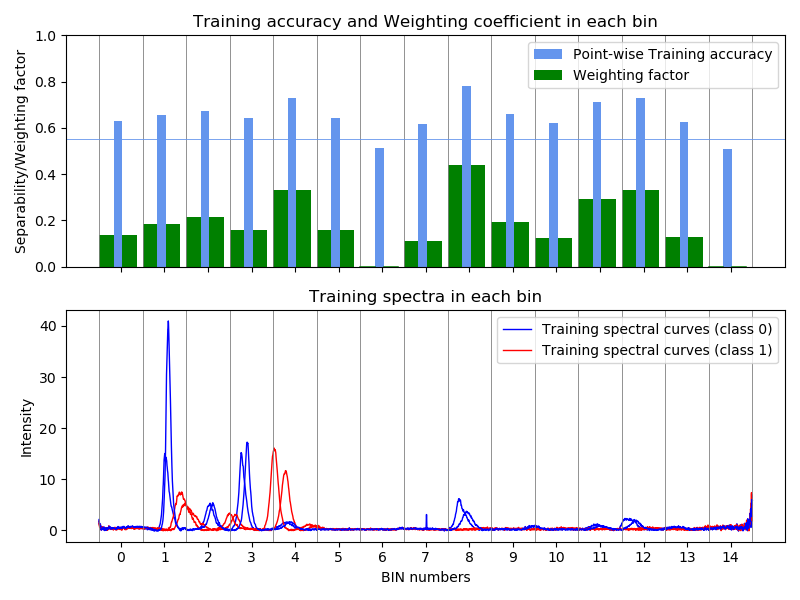

134 [ 9.5603831  10.62580132 11.69121955 12.75663778 13.82205601 14.88747423
 15.95289246 17.01831069 18.08372891 19.14914714 20.21456537 21.2799836
 22.34540182 23.41082005 24.47623828] <class 'torch.Tensor'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
15.95289246
24.47623828


In [34]:
x_data = np.zeros(B)
middle_acc   = int(N2/5)
middle_weigt = int(N2/3)


n = 0
for b in range(0,B):
    index=b*N2
    x_data[n] = theta[0][index]
    n = n+1
width_acc   =  theta[0][middle_acc]-theta[0][0]
width_weigt =  theta[0][middle_weigt]-theta[0][0]


W_np= W.numpy() 
Acc_np=Acc


middle_p   = int(N2/2)
x_dataTick = np.zeros(B)
labels     = np.arange(B)
n          = 0
for b in range(0,B):
    index         = b*N2+middle_p
    x_dataTick[n] = theta[0][index]
    labels[n]     = b
    n             = n+1


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.get_shared_x_axes().join(ax1, ax2)
    

ax1.set_ylabel('Separability/Weighting factor')#, fontsize = 16
ax1.set_ylim(0, 1)

rects1 = ax1.bar(x_data+width_weigt+width_acc/2, Acc_np,width_acc, color="cornflowerblue",label='Point-wise Training accuracy',)
rects2 = ax1.bar(x_data+width_weigt/2, W_np, width_weigt, color="green",label='Weighting factor',)
rects2 = ax1.bar(x_data+width_weigt+width_acc+width_weigt/2, W_np, width_weigt,color="green")
ax1.legend()
# ax1.legend(loc=2)
ax1.set_title('Training accuracy and Weighting coefficient in each bin')
# plt.grid(True)
# ax1.grid()
    
ax2.plot(Xtrain1[:,0], Xtrain1[:,1], color='blue', label='Training spectral curves (class 0)', linewidth=1)
ax2.plot(Xtrain2[:,0], Xtrain2[:,1], color='red', label='Training spectral curves (class 1)', linewidth=1)
ax2.plot(Xtrain3[:,0], Xtrain3[:,1], color='red',  linewidth=1)
ax2.plot(Xtrain4[:,0], Xtrain4[:,1], color='blue',  linewidth=1)
# ax2.set_xticks(x_dataTick,labels,)#fontsize=16
print(middle_p,x_data,type(W),type(W_np),type(Xtrain1))
ax2.set_ylabel('Intensity')#, fontsize = 16
ax2.set_xlabel('BIN numbers')#, fontsize = 16
ax2.legend()
ax2.set_title('Training spectra in each bin')

plt.xticks(x_dataTick,labels)#fontsize=16

# draw vertical line in bin boundary
for b in range(0,B):
    index         = b*N2
    xvline = theta[0][index]
    ax2.axvline(x=xvline, color="grey",lw=0.6)
    ax1.axvline(x=xvline, color="grey",lw=0.6)
    if W_np[b]==0:
        print(x_data[b])
        x_array0 = [theta[0][index],theta[0][index+middle_weigt]]
        x_array1 = [theta[0][index+middle_weigt+middle_acc],theta[0][index+middle_weigt*2+middle_acc]]
        y_point  = [0,0]
        ax1.plot(x_array0,y_point,color='green',lw=1.1)
        ax1.plot(x_array1,y_point,color='green',lw=1.1)
        
ax2.axvline(x=theta[0][N-1], color="grey",lw=0.6)
ax1.axvline(x=theta[0][N-1], color="grey",lw=0.6) 
ax1.axhline(y=0.55, color="cornflowerblue",lw=0.6) 


fig.tight_layout()
plt.tight_layout()
plt.show()
plt.savefig(save_figures_to+"Weight coefficient in each bin.png", bbox_inches='tight', dpi=300)


In [35]:
ytest_pred = torch.FloatTensor(ytest_pred)# convert list type to tensor
print((ytest_pred).shape)
ytest_pred=torch.reshape(ytest_pred,(-1,1))
ytest_pred = ytest_pred.to(device)
print((ytest_pred).shape)

y_pred_union = torch.FloatTensor(y_pred_union)# convert list type to tensor
print((y_pred_union).shape,N_Train*N2*B)
y_pred_union=torch.reshape(y_pred_union,(-1,1))
y_pred_union = y_pred_union.to(device)

torch.Size([15, 93532])
torch.Size([1402980, 1])
torch.Size([15, 11792]) 176880


# Initial point-wise classification result (without weighting technique)

torch.Size([1402980, 1])
torch.Size([1402980]) 1402980


<IPython.core.display.Javascript object>


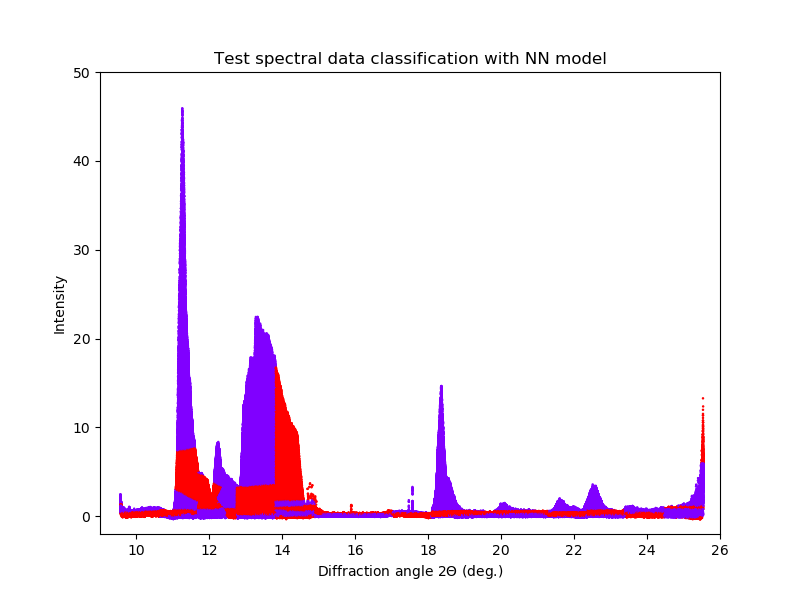

torch.Size([176880]) 176880


<IPython.core.display.Javascript object>


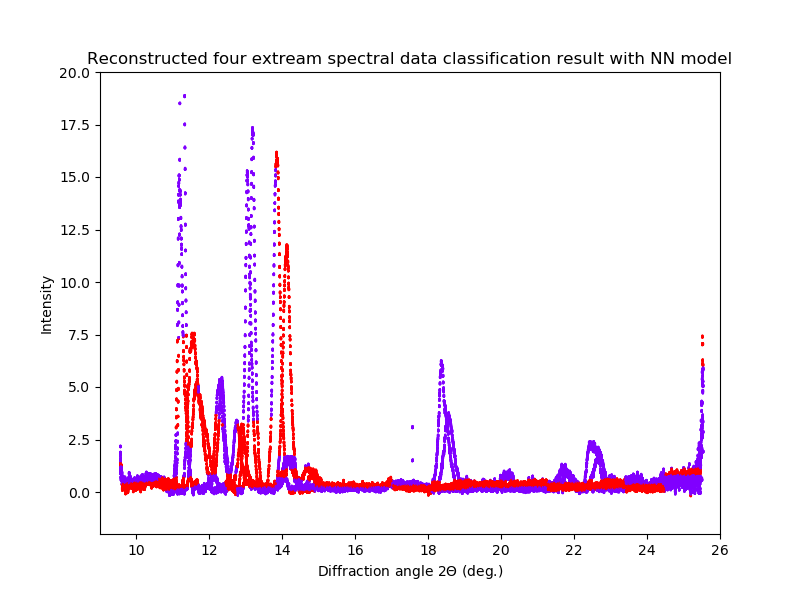

In [36]:
BINyt_pred = ytest_pred #.cpu()
print((BINyt_pred).shape)


Zt=torch.reshape(BINyt_pred,(-1,N2))
Zt_tmp=torch.empty(Ntn,0).to(device)

for b in range(B):
    Zt_tmp  = torch.cat([Zt_tmp,Zt[Ntn*b:Ntn*(b+1)]],dim=1)
    
Zt=torch.squeeze(torch.reshape(Zt_tmp,(1,-1))) # put all curves in one row, one curve after another curve.
print(Zt.shape,Ntn*N2*B)


plt.figure(figsize=(8,6))
byhigh=50
yue_plot_data(Xt, Zt, axl,axr,byl,byhigh)
plt.title('Test spectral data classification with NN model')
plt.savefig(save_figures_to+"test spectra data classification with NN model.png", bbox_inches='tight', dpi=300)


yBin_pred     =torch.reshape(y_pred_union,(-1,N2))
yBin_pred_tmp =torch.empty(N_Train,0).to(device)

for b in range(B):
    yBin_pred_tmp  = torch.cat([yBin_pred_tmp,yBin_pred[N_Train*b:N_Train*(b+1)]],dim=1)
    
yBin_pred      = torch.squeeze(torch.reshape(yBin_pred_tmp,(1,-1))) # put all curves in one row, one curve after another curve.
print(yBin_pred.shape,N_Train*N2*B)


plt.figure(figsize=(8,6))
byhigh=20
yue_plot_data(X_Extrem, yBin_pred, axl,axr,byl,byhigh)
plt.title('Reconstructed four extream spectral data classification result with NN model')
plt.savefig(save_figures_to+"Reconstructed four extream spectral data classification result with NN model.png", bbox_inches='tight', dpi=300)

class type: <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


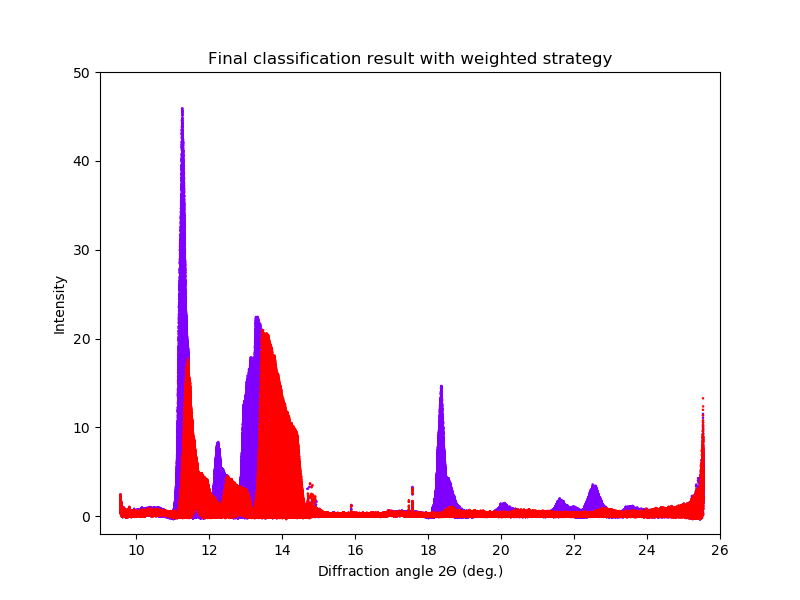

In [37]:
##### =================calculate the label for the whole curve ========================================================
#======================================================================================================================
Zt_temp= torch.zeros(N2)
score  = torch.zeros(C,B)
cla    = torch.zeros(C) # for the label 

Ct_prid=torch.zeros(N*Ntn, dtype=torch.long).to(device) # predicted test spectra label.
print('class type:',type(Ct_prid))
for j in range(Ntn): # test data sets(number of curves)
    for c in range(C):  #class     
        for i in range(B):   #bins
#             for ic in range(N2): # (number of data points in each bin per curve)
#                 Zt_temp[ic]=BINyt_pred[ic+i*N2*Ntn+j*N2] # i represents which bin,c represents which class.
            Zt_temp=BINyt_pred[(i*N2*Ntn+j*N2):(i*N2*Ntn+(j+1)*N2)] # i represents which bin,c represents which class.
            score[c,i] = (Zt_temp == c).sum().float()*W[i]
    cla  = torch.sum(score,dim=1)
    cla /= N  #Classication Result

    
    classId=np.argmax(cla)
    
    for k in range(N):
        Ct_prid[k+j*N]=classId



plt.figure(figsize=(8,6))
yue_plot_data(Xt, Ct_prid, axl,axr,byl,byh)
plt.title('Final classification result with weighted strategy')#,fontsize=16
plt.savefig(save_figures_to+"Final classification result with weighted strategy.png", bbox_inches='tight', dpi=300)

# ambiguous region in test spectra

In [38]:
# to define the  correctly classified interval, and the low confidence interval

var_C0=0
for j in range(Ntn-1): # test data sets(curves)

    
    if Ct_prid[j*N]== 0 and Ct_prid[(j+1)*N]==0:
        var_C0 = j+1
    else:
        break       
print(var_C0)   

var_C1=Ntn-1
for j in range(Ntn-1,0,-1): # test data sets(curves)   
    if Ct_prid[j*N] == 1 and Ct_prid[(j-1)*N]==1:
        var_C1 = j-1
    else:
        break
print(var_C1)  
glo_acc = 1-float((var_C1-var_C0-1)/Ntn)
print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
print("Overall classification accuracy is %.3f" % (glo_acc*100)+"%")

194
195
Interval with low classification confidence is (194 ,  195)
Overall classification accuracy is 100.000%


# For curves between two extreme curves

In [39]:
gap = 20
p_start = p0_num*gap
p_end = p1_num*gap
print(p_start,p_end)
print(Zt.shape,Zt[p_start*D_len:(p_start+1)*D_len].shape,D_len*349)

80 300
torch.Size([1402980]) torch.Size([4020]) 1402980


In [40]:
D_len=N # the number of points of one curve
total_n = len(range(p_start,p_end))

# different type of labels:
PCt_prid = Ct_prid[p_start*D_len:p_end*D_len] # Final predicted label with model and weights
PZt      = Zt[p_start*D_len:p_end*D_len] # label directly predicted by the model

# values of x-axis and y-axis
PXt_y    = torch.zeros(D_len*total_n) # Xt[p_start*D_len:p_end*D_len]
PXt_x    = torch.zeros(D_len*total_n) # Xt[p_start*D_len:p_end*D_len]


n=0
for j in range(p_start,p_end):    
    PXt_y[n*D_len:(n+1)*D_len] = Xt[j*D_len:(j+1)*D_len,1]+6-j/1. # intensity
    PXt_x[n*D_len:(n+1)*D_len] = Xt[j*D_len:(j+1)*D_len,0] # theata    
    n = n+1
    
PXt_x = torch.reshape(PXt_x,(-1,1)) # to a vector:from torch.Size([80460]) to torch.Size([80460, 1])
PXt_y = torch.reshape(PXt_y,(-1,1)) # to a vector:from torch.Size([80460]) to torch.Size([80460, 1])
PXt   = torch.cat((PXt_x,PXt_y),1).to(device)

print(PXt.shape,Xt.shape)

torch.Size([884400, 2]) torch.Size([1402980, 2])


<IPython.core.display.Javascript object>


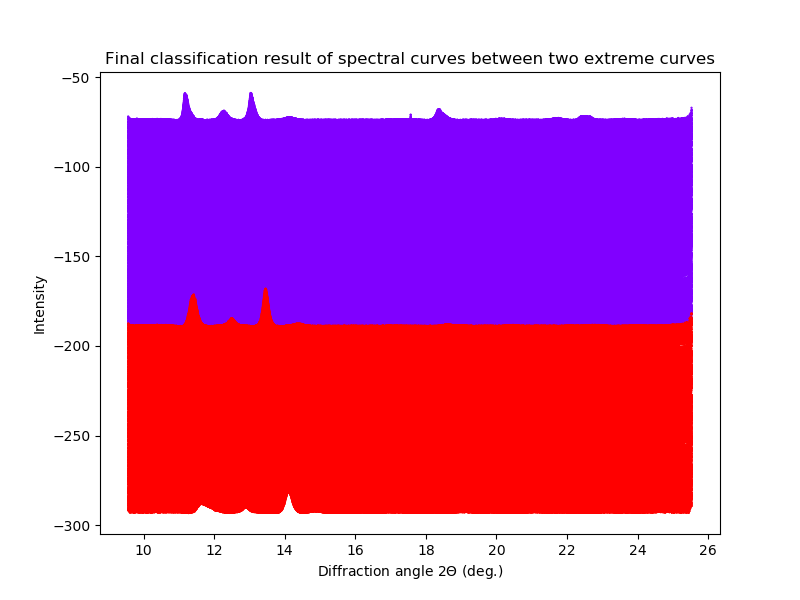

<IPython.core.display.Javascript object>


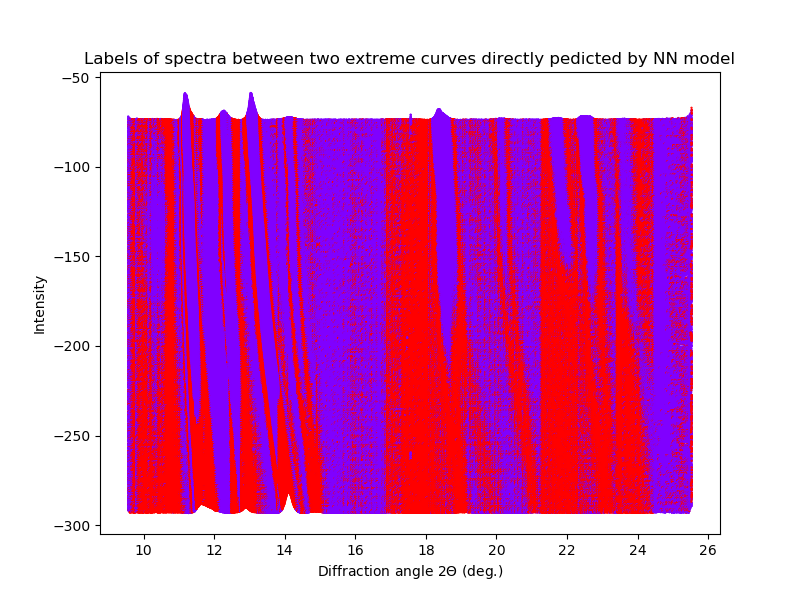

In [41]:
plt.figure(figsize=(8,6))
# yue_plot_data(PXt, PCt_prid, axl,axr,Pbyl,Pbyh)
plot_data(PXt, PCt_prid)
plt.title('Final classification result of spectral curves between two extreme curves', )#fontsize = 14
plt.savefig(save_figures_to+"Final classification result of spectral curves between two extreme curves.png", bbox_inches='tight', dpi=300)


plt.figure(figsize=(8,6))
# yue_plot_data(PXt, PZt, axl,axr,Pbyl,Pbyh)
plot_data(PXt, PZt)
plt.title('Labels of spectra between two extreme curves directly pedicted by NN model', )#fontsize = 14
plt.savefig(save_figures_to+"Label of spectra between two extreme curves directly pedicted by the model.png", bbox_inches='tight', dpi=300)

# overall trend-every twentieth

In [42]:
interval=20
total_n = len(range(0,Ntn,interval))
# different type of labels: colors

PCt_prid_gap = torch.zeros(D_len*total_n) # Final predicted label with model and weights
PZt_gap      = torch.zeros(D_len*total_n) # label directly predicted by the model
# values of x-axis and y-axis
PXt_val_y    = torch.zeros(D_len*total_n) # with flattening
PXt_val_x    = torch.zeros(D_len*total_n) # with flattening
Xt_trd       = torch.zeros(D_len*total_n,2) # without flattening

n=0
# for j in range(p_start,p_end,interval):
for j in range(0,Ntn,interval):
    
    PXt_val_y[n*D_len:(n+1)*D_len] = Xt[j*D_len:(j+1)*D_len,1]+6-j/1. # intensity
    PXt_val_x[n*D_len:(n+1)*D_len] = Xt[j*D_len:(j+1)*D_len,0] # theata
    
    Xt_trd   [n*D_len:(n+1)*D_len,:] = Xt[j*D_len:(j+1)*D_len,:] # intensity
    
    # different type of labels:
    PCt_prid_gap[n*D_len:(n+1)*D_len] = Ct_prid[j*D_len:(j+1)*D_len] # Final predicted label with model and weights
    PZt_gap[n*D_len:(n+1)*D_len]      = Zt[j*D_len:(j+1)*D_len] # label directly predicted by the model   
    n = n+1
    
PXt_val_x=torch.reshape(PXt_val_x,(-1,1)) # to a vector:from torch.Size([80460]) to torch.Size([80460, 1])
PXt_val_y=torch.reshape(PXt_val_y,(-1,1)) # to a vector:from torch.Size([80460]) to torch.Size([80460, 1])

PXt_val=torch.cat((PXt_val_x,PXt_val_y),1).to(device) # with flattening
Xt_trd =Xt_trd.to(device)  # without flattening
print(Xt.shape,PXt_val_y.shape,PXt_val.shape, Xt_trd.shape)

torch.Size([1402980, 2]) torch.Size([72360, 1]) torch.Size([72360, 2]) torch.Size([72360, 2])


<IPython.core.display.Javascript object>


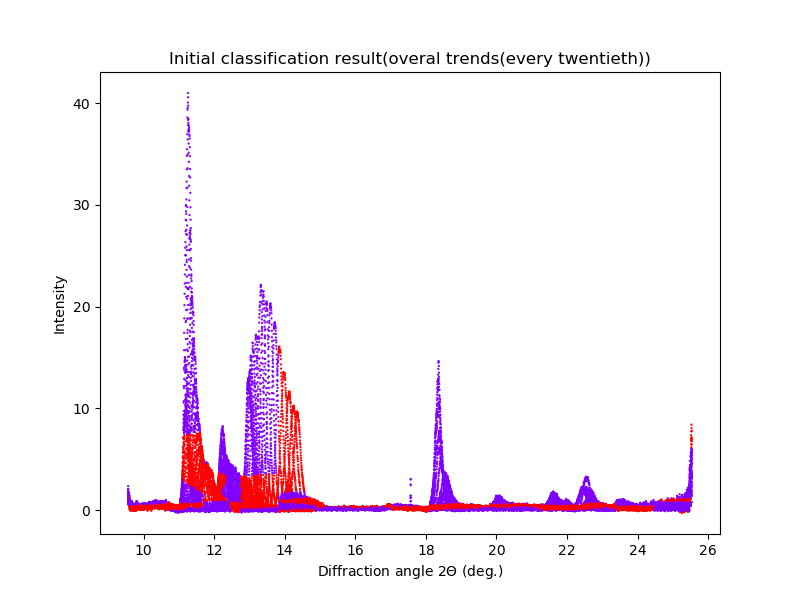

<IPython.core.display.Javascript object>


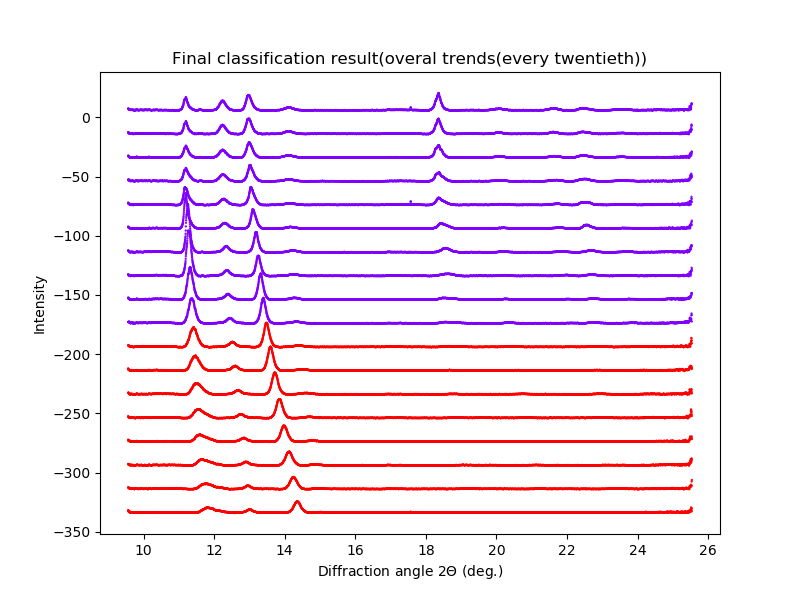

<IPython.core.display.Javascript object>


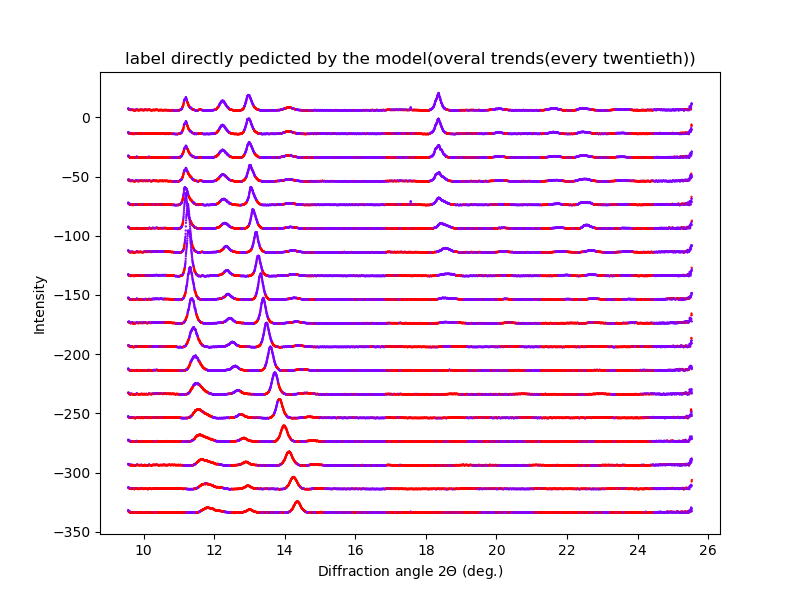

In [43]:
plt.figure(figsize=(8,6))
plot_data(Xt_trd, PZt_gap)
plt.title('Initial classification result(overal trends(every twentieth))')#,fontsize=16


plt.figure(figsize=(8,6))
plot_data(PXt_val, PCt_prid_gap)
plt.title('Final classification result(overal trends(every twentieth))')#,fontsize=16
plt.savefig(save_figures_to+"Final classification result(overal trends-every twentieth).png", bbox_inches='tight', dpi=300)


plt.figure(figsize=(8,6))
plot_data(PXt_val, PZt_gap)
plt.title('label directly pedicted by the model(overal trends(every twentieth))')#,fontsize=16
plt.savefig(save_figures_to+"Final classification result(overal trends-every twentieth).png", bbox_inches='tight', dpi=300)

# Curves near the boundary

In [44]:
if var_C0==Ntn-1:
    p_start0 = 0 # start curve
    p_end0   = Ntn # end curv   
elif var_C1==0:
    p_start0 = 0 # start curve
    p_end0   = Ntn # end curv  
else:
    p_start0 = var_C0-5 if var_C0>5 else  var_C0 # start curve
    p_end0   = var_C1+5  if var_C1+5<=Ntn else Ntn

print(p_start0,p_end0)

189 200


In [45]:
D_len=N
# different type of labels:
PCt_prid0 = Ct_prid[p_start0*D_len:p_end0*D_len] # Final predict label with model and weights
PZt0      = Zt[p_start0*D_len:p_end0*D_len] # label directly predicted by the model
# values of x-axis and y-axis
PXt0      = torch.zeros((p_end0-p_start0)*D_len,2)
Xt_temp   = Xt[p_start0*D_len:p_end0*D_len,:]
print(PXt0.shape,Xt.shape)


n=0
for j in range(p_start0,p_end0):    
#     PXt0[(j-p_start0)*D_len:(j+1-p_start0)*D_len,1] = Xt[j*D_len:(j+1)*D_len,1]+6-j/1.
    PXt0[n*D_len:(n+1)*D_len,1] = Xt_temp[n*D_len:(n+1)*D_len,1]+6-j/1.
    PXt0[n*D_len:(n+1)*D_len,0] = Xt_temp[n*D_len:(n+1)*D_len,0]
    n=n+1
    
print(PXt0.shape,Xt.shape)

torch.Size([44220, 2]) torch.Size([1402980, 2])
torch.Size([44220, 2]) torch.Size([1402980, 2])


<IPython.core.display.Javascript object>


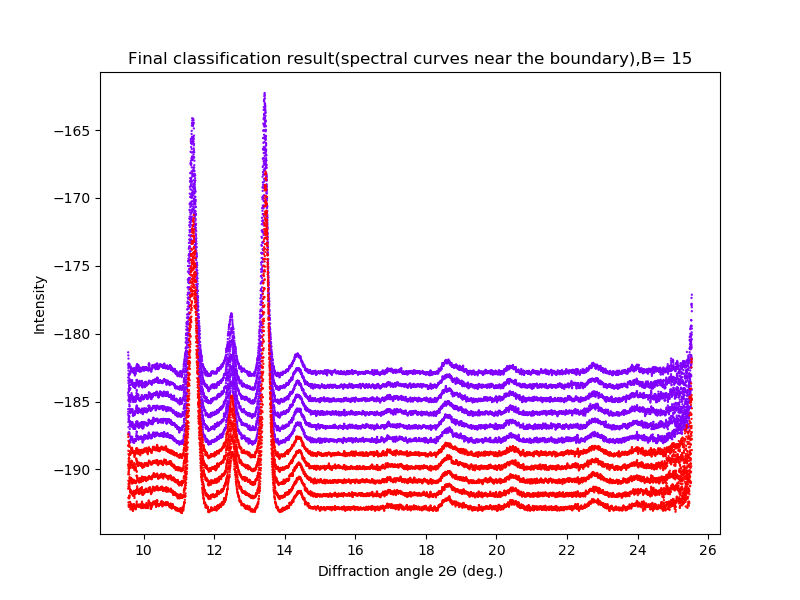

<IPython.core.display.Javascript object>


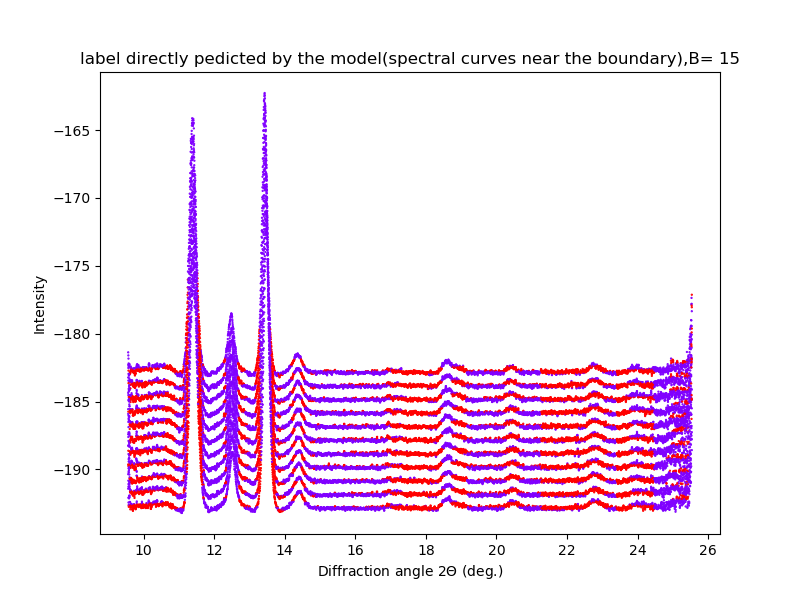

In [46]:
plt.figure(figsize=(8,6))
# yue_plot_data(PXt0, PCt_prid0, axl,axr,Pbyl,Pbyh)
plot_data(PXt0, PCt_prid0)
plt.title('Final classification result(spectral curves near the boundary),B= %i'% (B))
plt.savefig(save_figures_to+"Final classification result(spectral curves near the boundary).png", bbox_inches='tight', dpi=300)

plt.figure(figsize=(8,6))
# yue_plot_data(PXt0, PZt0, axl,axr,Pbyl,Pbyh)
plot_data(PXt0, PZt0)
plt.title('label directly pedicted by the model(spectral curves near the boundary),B= %i'% (B))
plt.savefig(save_figures_to+"'label directly pedicted by the model(spectral curves near the boundary),B= %i'.png"% (B), bbox_inches='tight', dpi=300)

# References

[1].	Pennicard, D., Smoljanin, S., Pithan, F., Sarajlic, M., Rothkirch, A., Yu, Y., Liermann, H.P., Morgenroth, W., Winkler, B., Jenei, Z. and Stawitz, H., 2018. LAMBDA 2M GaAs—A multi-megapixel hard X-ray detector for synchrotrons. Journal of Instrumentation, 13(01), p.C01026.  [10.1088/1748-0221/13/01/C01026]